In [1]:
import numpy as np
from importlib import reload
from scipy import signal

import plotting_tools as pt
import utils
import dsi
utils = reload(utils)
pt = reload(pt)
dsi = reload(dsi)

import pickle
import sys
# Notebook needs to see the RKLM_Python module to load pickled class instances
sys.path.append('../RKLM_Python/')

In [2]:
Nx, Ny, Nz = 256, 1, 256
et = 720.0

def load(Nx,Ny,et):
    base_fn = 'output_swe_dvortex'
    pydir = '../%s/' %base_fn

    tc = utils.test_case(base_fn, pydir, Nx, Ny, et, Nz=Nz)
    tags = tc.get_tag_dict()
    
    return tc, tags
tc, tags = load(Nx,Ny,et)

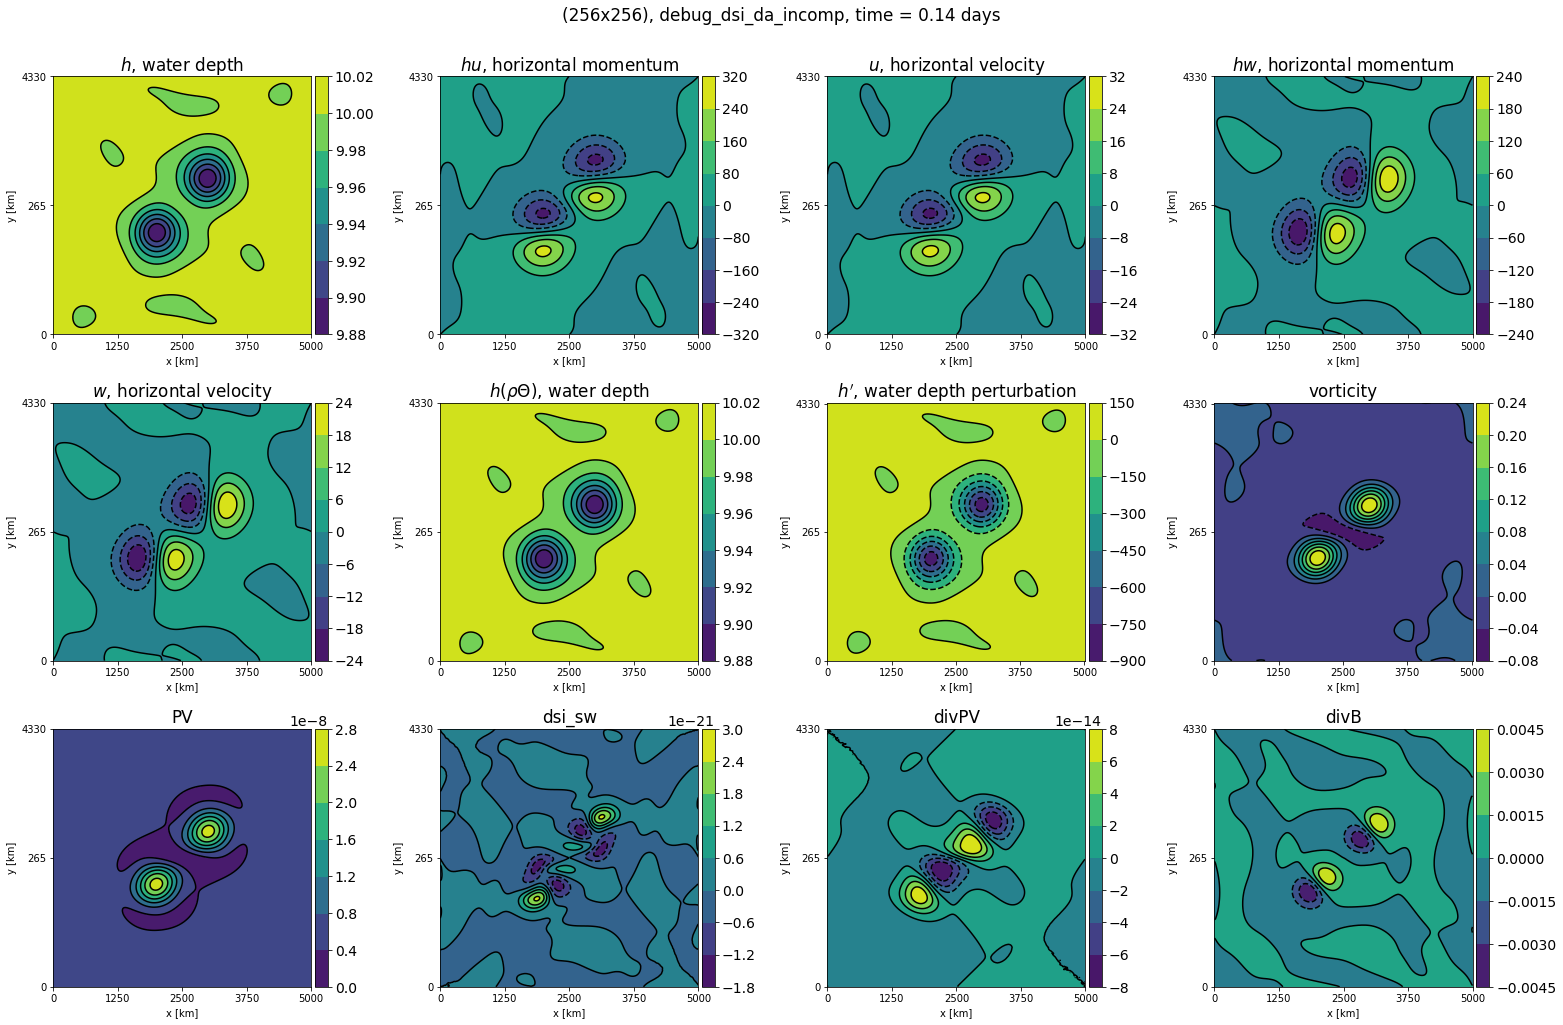

In [3]:
N = 1
sfx0 = 'dvortex_comp_geostrophic'
sfx0 = 'debug_dsi_da_incomp'
sfx = sfx0 + '_vw_wind'
sfx = sfx0 + '_last_working_1'
sfx = sfx0

fn_pickle = tc.get_filename(N,sfx0,format='dat')
path_pickle = tc.get_path(fn_pickle)
fn = tc.get_filename(N,sfx)
path = tc.get_path(fn)

attributes = ['rho','rhou','rhow','rhoY','p2_nodes','vorty']
t_lbl = 'TIME'
slc = 0

times = np.array([72.0]) * 10.0
times = np.arange(0,720.0+72.0,72.0)
times = np.arange(0,720.0+1.0,1.0)
# times = np.arange(0,360.0+72.0,72.0)
tag = tags[9]
plot_lbls = pt.lake_labels()
plot_lbls = pt.swe_labels()

# load pickled data
file = open(path_pickle,'rb')
ud = pickle.load(file)
elem = pickle.load(file)
node = pickle.load(file)
file.close()

dx = np.diff(elem.x)[0] * ud.h_ref
dy = np.diff(elem.z)[0] * ud.h_ref

class oo(object): pass
data = oo()

# g = ud.gravity_strength[1]
g = 9.81

debug = True
if debug == True: arr_lst = []
time_series = np.zeros((times.shape[0],len(attributes)+6,2), dtype='object')

for tt,time in enumerate(times):
    tag = 'ic' if tt == 0 else tags[9]
    plt_cnt = 0
    for atr_idx, attribute in enumerate(attributes):
        arr = tc.get_arr(path, time, N, attribute, label_type=t_lbl, tag=tag, inner=True, avg=False)[0][:,slc,:]
        arr = arr.T
        arr0 = np.copy(arr)
        
        setattr(data,attribute,arr)
        
        arr = [arr, plot_lbls[attribute]]
        time_series[tt,plt_cnt] = arr
        plt_cnt += 1
        if attribute == 'rhou' or attribute == 'rhow':
            arr0 /= data.rho
            attribute = attribute[-1]
#             arr0 = [arr0, r'$%s^{(0)}$' %attribute]
            arr0 = [arr0, r'$%s$, horizontal velocity' %attribute]
            time_series[tt,plt_cnt] = arr0
#             print(attribute,plt_cnt)
            plt_cnt += 1
        
    # Calculate DSI_SW
    dsi_sw, PV, B = dsi.get_DSI_SW(data, g, ud, elem)
    divPV = dsi.grad(PV,dx,'x') + dsi.grad(PV,dy,'y')
    divB = dsi.grad(B,dx,'x') + dsi.grad(B,dy,'y')
    PV = [PV, 'PV']
    dsi_sw = [dsi_sw,'dsi_sw']
    
    divPV = [divPV, 'divPV']
    divB = [divB, 'divB']
    
    time_series[tt,plt_cnt] = PV
    time_series[tt,plt_cnt+1] = dsi_sw
    time_series[tt,plt_cnt+2] = divPV
    time_series[tt,plt_cnt+3] = divB

if debug == True:
    idx = 10
    fs = (22,5.5)
    fs = (22,15)
    # fs = (6,6)
    ncolslen = int((len(attributes))/2) if len(attributes) > 1 else 1
    ncolslen = 4
    pl = pt.plotter(time_series[idx],ncols=ncolslen,figsize=fs,sharey=False)

    x_axs = [0,1250,2500,3750,5000]
    y_axs = [0,265,4330]
    x_loc = np.linspace(0,Nx-1,5)
    y_loc = np.linspace(0,Nz-1,3)
    x_label = r'x [km]'
    y_label = r'y [km]'
    st = 'SWE shear flow (%ix%i), $\Delta t = 12s$. Potential vortcity in the (x-z) plane.' %(Nx,Nz)
    st = '(%ix%i), %s, time = %.2f days' %(Nx,Nz, sfx, times[idx]*1200/(3600*24))

    pl.set_axes(x_locs=x_loc, y_locs=y_loc, x_axs=x_axs, y_axs=y_axs, x_label=x_label, y_label=y_label)
    _ = pl.plot(aspect='equal',method='contour',suptitle=st)
    pl.save_fig('./output/ivg_%idays' %(times[idx]*1200/(3600*24)))

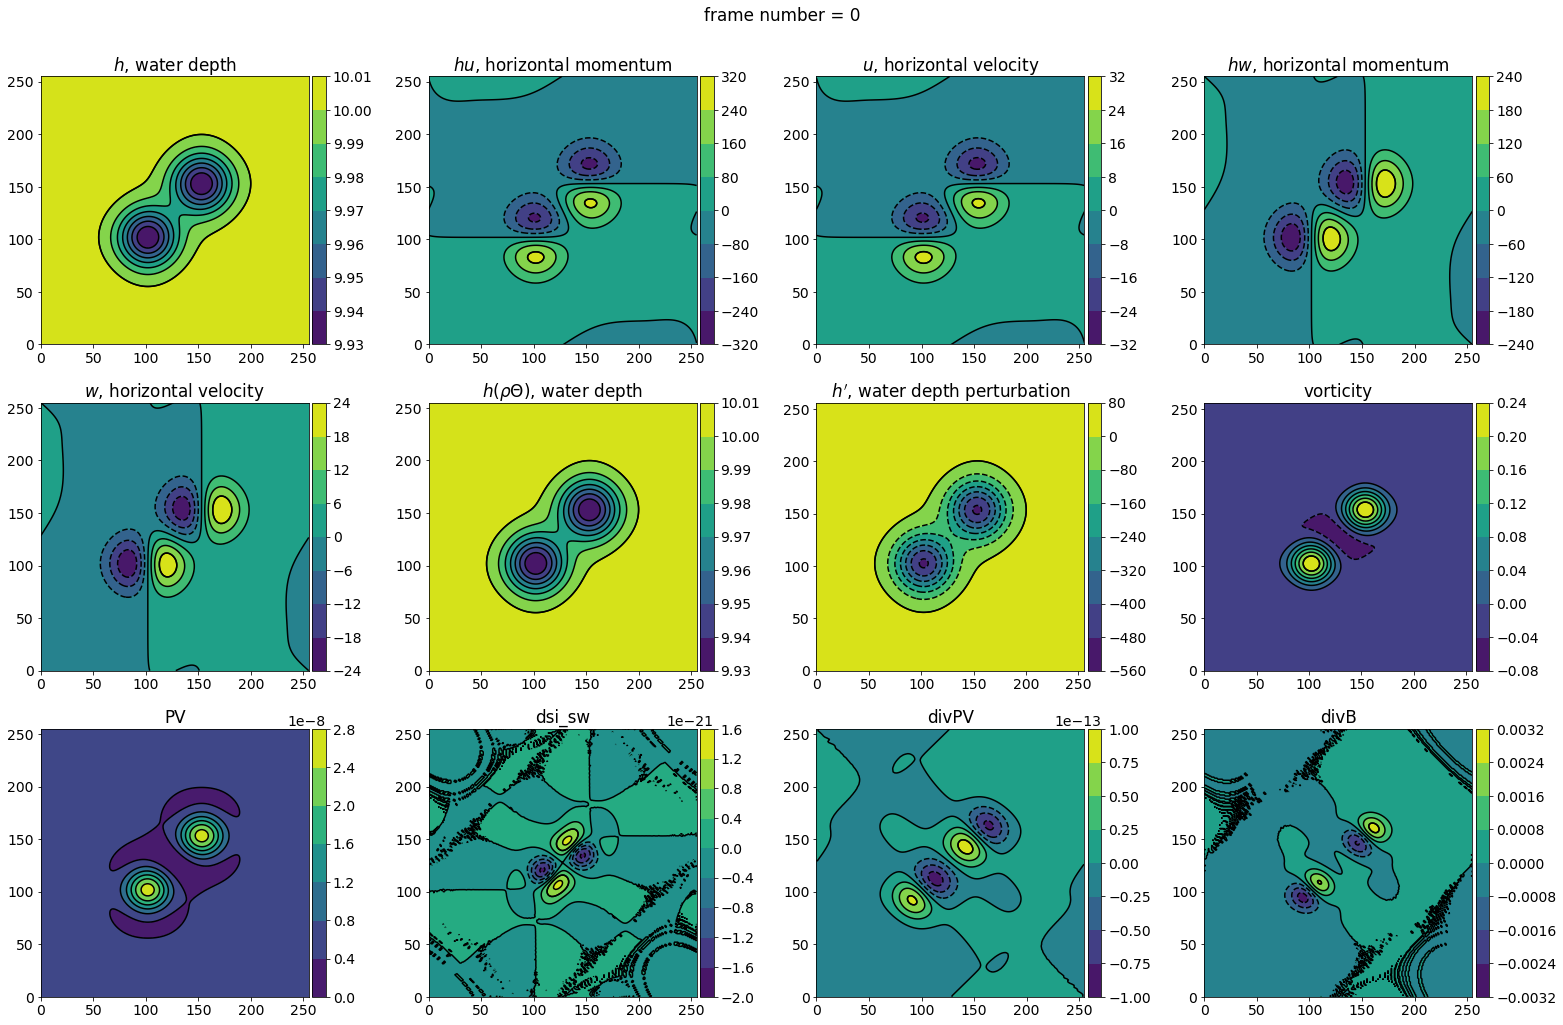

In [4]:
import plotting_tools as pt
pt = reload(pt)

def title_gen(frn):
    return "frame number = %i" %frn

-------- Weitergeleitete Nachricht --------
Betreff: 	Fw: [scientists] ISTernship 2021 call - please help spread the word
Datum: 	Mon, 18 Jan 2021 15:39:42 +0000
Von: 	Hana KOURIMSKA
An: 	Tanja Fagel 
fs = (22,15)
a2d = pt.animator_2D(time_series,ncols=4,figsize=fs)
a2d.suptitle = title_gen
a2d.method = 'contour'
anim = a2d.animate(interval=350, aspect='equal', method='contour')

In [5]:
import matplotlib.animation as animation

Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Ray Chew'), bitrate=1800)
anim.save('./output/%i_%i_dvortex_%s.mp4' %(Nx,Nz,sfx), writer=writer)